# Modelamiento
----------------------------------------------

MLDS 6 - Grupo 8


### Librerias y configuraciones

In [54]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
tf.random.set_seed(42)

In [52]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))

  return df

## Lectura de sub conjunto de datos de train y test
-----------------------------------

Se cargan los datos resultado de la sección de preprocesamiento, y se verifica que no haya un cambio en sus dimensiones.

In [6]:
data = np.load("/home/kevo/Escritorio/mlds6/tdsp_template_grupo8/scripts/preprocessing/train_test_array.npz")
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
print(f'Dimensiones X_train: {X_train.shape}')
print(f'Dimensiones X_test: {X_test.shape}')
print(f'Dimensiones y_train: {y_train.shape}')
print(f'Dimensiones y_test: {y_test.shape}')

Dimensiones X_train: (76916, 15)
Dimensiones X_test: (19230, 15)
Dimensiones y_train: (76916,)
Dimensiones y_test: (19230,)


## Análisis de modelos de Machine learning
---------------------------------------
En esta etapa se utilizaran algoritmos supervisados con validacion cruzada K-fold para encontrar el mejor modelo y los hiperparametros mas adecuados para la clasificación que se desea obtener.

## Regresion logistica
----------------------------------------
Se selecciono la técnica de regresión logística debido a su eficiencia y robustez para clasificación binaria, ademas de su eficiecnia computacional. Para la validación cruzada se tendran en cuenta, hiperparametros como: el tipo de optimizacion, solver, y las iteraciones maximas. 

In [21]:
param_grid = {
    'penalty': ['l2', None],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 400, 800],
}

Se utiliza la herramienta gridsearchcv para la que se configura para 5 particiones al realizar CV

In [43]:
grid_lg = GridSearchCV(LogisticRegression(random_state=3,),
                   param_grid=param_grid,
                   verbose=1,
                   return_train_score=True,
                   cv = 5
                   )
grid_lg.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=3),
             param_grid={'max_iter': [100, 200, 400, 800],
                         'penalty': ['l2', None], 'solver': ['lbfgs']},
             return_train_score=True, verbose=1)

Se realiza un dataframe que contiene los mejores score de los primeros modelos entrenados, este indica los hiperparametros seleccionados en cada iteración, asi como las metricas obtenicas por cada split y su respectivo promedio y desviacion estandar al final.

In [44]:
pd.DataFrame(grid_lg.cv_results_).sort_values(by='rank_test_score', ascending=True).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.315356,0.029572,0.006032,0.000161,100,l2,lbfgs,"{'max_iter': 100, 'penalty': 'l2', 'solver': '...",0.958788,0.958591,...,0.958734,0.001239,1,0.958656,0.958884,0.958543,0.958364,0.959258,0.958741,0.000309
2,0.285413,0.053993,0.005806,0.000208,200,l2,lbfgs,"{'max_iter': 200, 'penalty': 'l2', 'solver': '...",0.958788,0.958591,...,0.958734,0.001239,1,0.958656,0.958884,0.958543,0.958364,0.959258,0.958741,0.000309
6,0.555815,0.157849,0.019346,0.016326,800,l2,lbfgs,"{'max_iter': 800, 'penalty': 'l2', 'solver': '...",0.958788,0.958591,...,0.958734,0.001239,1,0.958656,0.958884,0.958543,0.958364,0.959258,0.958741,0.000309


Se extrae los mejores parametros del modelo, que en el caso de la regresión logística es, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', logrando un score de 0.958 para entrenamiento y 0.9596 con datos de prueba. Lo que indica que la variacion de accuraccy utilizando datos no vistos en el entrenamiento y datos si utilizados es muy pequeña, sin embargo para saber si es un modelo bueno se necesita conocer otras metricas.

In [60]:
print(grid_lg.best_params_)
print(grid_lg.best_score_)
print(grid_lg.score(X_test, y_test))

{'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9587342028427285
0.959594383775351


Se almacena el mejor modelo de LR con joblib, para evitar volver a aplicar gridsearchCV

In [61]:
lg_bm = grid_lg.best_estimator_
joblib.dump(lg_bm, 'lg_best_model.joblib')

['lg_best_model.joblib']

Se carga el mejor modelo y se reliza una predicción

In [62]:
model_lg = joblib.load("lg_best_model.joblib")
y_pred_lg = model_lg.predict(X_test)

Con las prediccion se genera un clasification report para saber como esta el rendimiento de LR.

In [63]:
print(classification_report(y_test,y_pred_lg, target_names=['No_Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No_Diabetes       0.97      0.99      0.98     17534
    Diabetes       0.87      0.64      0.73      1696

    accuracy                           0.96     19230
   macro avg       0.92      0.81      0.86     19230
weighted avg       0.96      0.96      0.96     19230



Se genera un matriz de confusión que indica que la mayoria de casos con personas que no padecen diabetes es clasificado satisfactoriamente, pero con respecto a las personas que padecen diabetes, un porcentaje considerable esta mal clasificado lo que indica que este algoritmo tiene problemas para clasificar algunos casos en los cuales la diabetes es positiva. 

In [64]:
lg_mat = confusion_matrix(y_test, y_pred_lg)
list_confusion_matrix(lg_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17376      158
           Diabetes               619     1077

# C-Support Vector Classification.
--------------------------------------------
Otro algorimo utilizado es el super vector machine para clasificación, que se caraxteriza por buscar una region optima que separe diferentes clases de datos en un margen considerable. Es decir que buscar un hiperplano que maxime la distancia entre las clases que se necesite diferenciar, ademas que puede trabajar en casos de linealidad y no linealidad. Para nuestro caso vamos a probar, variando hiperparametros como el tipo de kernel, la tasa de optimizacion "C" y el valor de gamma.

In [32]:
param_grid_svc = {
    'kernel': ['linear','rbf', 'sigmoid'],
    'C': [0.001 ,0.01, 0.1],
    'gamma': ['scale', 'auto', float]
}

Se genera la herramiento gridSearchCv, configruada para 5 folds

In [33]:
grid_svc = GridSearchCV(SVC(random_state=3),
                   param_grid=param_grid_svc,
                   verbose=1,
                   return_train_score=True,
                   cv = 5
                   )
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=3),
             param_grid={'C': [0.001, 0.01, 0.1],
                         'gamma': ['scale', 'auto', <class 'float'>],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             return_train_score=True, verbose=1)

Se crea un dataframe con los resultados de los 3 primeros modelos, donde encuentra los hiperparateros, y las metricas especificas y generales de cada iteración.

In [36]:
pd.DataFrame(grid_svc.cv_results_).sort_values(by='rank_test_score', ascending=True).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
21,18.610979,0.091407,3.214798,0.013363,0.1,auto,linear,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.959958,0.958526,...,0.958526,0.001095,1,0.958282,0.958738,0.958429,0.958266,0.959144,0.958572,0.000332
18,18.761773,0.088537,3.216793,0.022473,0.1,scale,linear,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.959958,0.958526,...,0.958526,0.001095,1,0.958282,0.958738,0.958429,0.958266,0.959144,0.958572,0.000332
19,29.470915,0.232364,9.436970,0.034859,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.958398,0.956835,...,0.957083,0.001090,3,0.957161,0.957437,0.957177,0.957161,0.957974,0.957382,0.000314


Por separado, se extraen del mejor modelo, sus hiperametros y sus metricas de entrenamiento y prueba.

In [65]:
print(grid_svc.best_estimator_)
print(grid_svc.best_score_)
print(grid_svc.score(X_test, y_test))

SVC(C=0.1, kernel='linear', random_state=3)
0.9585261657882294
0.9593863754550181


Se almacena el mejor modelo de SVC para evitar volver a aplicar la CV

In [66]:
svc_bm = grid_svc.best_estimator_
joblib.dump(svc_bm, 'svc_best_model.joblib')

['svc_best_model.joblib']

Se carga el mejor modelo y se obtienen predicciones

In [67]:
model_svc = joblib.load("svc_best_model.joblib")
y_pred_svc = model_svc.predict(X_test)

Se obtiene el clasification report de SVC

In [68]:
print(classification_report(y_test,y_pred_svc, target_names=['No_Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No_Diabetes       0.96      1.00      0.98     17534
    Diabetes       0.94      0.58      0.72      1696

    accuracy                           0.96     19230
   macro avg       0.95      0.79      0.85     19230
weighted avg       0.96      0.96      0.95     19230



La matriz de confusión muestra que solo 78 casos de no diabetes fueron mal clasificados por lo que el algrotimo funciona bien clasificando este tipo. Pero, el porcentaje de casos de diabetes que fueron bien clasificados estan cercanos a los que no fueron bien clasificados, lo que indica que el algoritmo tiene problemas al decidir a que tipo de clase pertenece un registro u otro de manera mas frecuente.

In [69]:
svc_mat = confusion_matrix(y_test, y_pred_svc)
list_confusion_matrix(svc_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17466       68
           Diabetes               713      983

## **K-NEAREST NEIGHBORS CLASSIFIER**

### **Training KNN- Classifier**

In [ ]:
param_grid = {
    'n_neighbors': list(range(2, 8)),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
}

In [ ]:
gsearch = GridSearchCV(
                      estimator=KNeighborsClassifier(),
                      param_grid=param_grid,
                      verbose=3,
                      cv=3,
                      n_jobs = -1,
                      scoring='accuracy',
                      return_train_score=True
          ).fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
#Cálculo de los resultados del Grid
pd.DataFrame(gsearch.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.247543,0.013183,24.119129,1.553438,2,2,uniform,"{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}",0.960178,0.958033,0.959435,0.959215,0.000889,1,0.970552,0.971742,0.970923,0.971072,0.000497
22,0.217192,0.004972,24.433652,1.463203,7,2,uniform,"{'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}",0.960178,0.958384,0.958889,0.959150,0.000755,2,0.964916,0.964955,0.965697,0.965189,0.000359
20,0.437372,0.016622,30.446183,1.138655,7,1,uniform,"{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",0.959749,0.958150,0.959318,0.959072,0.000676,3,0.964916,0.964936,0.965580,0.965144,0.000308
10,0.224421,0.004617,24.248166,1.108269,4,2,uniform,"{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}",0.960490,0.957565,0.958967,0.959007,0.001195,4,0.965657,0.966827,0.966165,0.966216,0.000479
18,0.222154,0.005672,24.523947,0.495411,6,2,uniform,"{'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}",0.960295,0.958345,0.958382,0.959007,0.000911,5,0.963648,0.964136,0.964722,0.964169,0.000439


In [ ]:
print(gsearch.best_estimator_)
print(gsearch.best_score_)

KNeighborsClassifier(n_neighbors=2)
0.959215250662576


In [ ]:
model = gsearch.best_estimator_
joblib.dump(model, "KNN_model.joblib")

['KNN_model.joblib']

### **Evaluation KNN- Classifier**

In [ ]:
model = joblib.load("KNN_model.joblib")

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Generación de la matriz de confusión.
KNN_mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(KNN_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17452       82
           Diabetes               665     1031

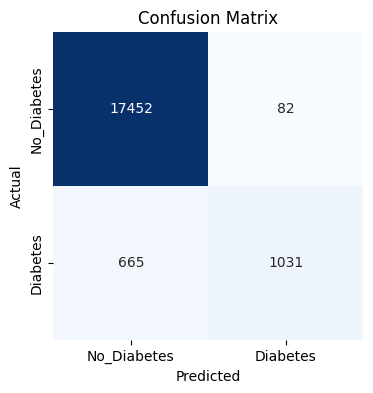

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(KNN_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Estimación de los estadísticos de desempeño del modelo.
print(f'Orden de las etiquetas: {names}')
print(f'Precisión por clase: \t{precision_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{f1_score(y_test, y_pred, average=None)}')

Orden de las etiquetas: ['No_Diabetes', 'Diabetes']
Precisión por clase: 	[0.96329414 0.92632525]
Recall por clase: 	[0.99532337 0.60790094]
Recall por clase: 	[0.97904687 0.73406906]


## **STOCHASTIC GRADIENT DESCENT CLASSIFIER**

### **Training SGD- Classifier**

In [ ]:
penalty = ['l1']
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
max_iter = [int(x) for x in np.linspace(1000, 10000, num = 19)]
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge',
'perceptron']
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]

random_grid = {
    'penalty' : penalty,
    'alpha' : alpha,
    'max_iter' : max_iter,
    'loss': loss,
    'learning_rate' : learning_rate,
    'class_weight' : class_weight,
    'eta0' : eta0
}

In [ ]:
SGDsearch = RandomizedSearchCV(
                            estimator=SGDClassifier(),
                            param_distributions=random_grid,
                            verbose=3,
                            cv=3,
                            n_iter=20,
                            n_jobs = -1,
                            scoring='accuracy',
                            return_train_score=True
        ).fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
#Cálculo de los resultados del Grid
pd.DataFrame(SGDsearch.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_max_iter,param_loss,param_learning_rate,param_eta0,param_class_weight,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,0.131269,0.000533,0.005045,0.000093,l1,7500,hinge,optimal,100,"{1: 0.7, 0: 0.3}",...,0.957565,0.957758,0.957577,0.000143,1,0.957291,0.957369,0.958403,0.957688,0.000507
17,1.296395,0.366456,0.006080,0.001413,l1,1000,modified_huber,adaptive,1,"{1: 0.7, 0: 0.3}",...,0.955146,0.953311,0.954171,0.000754,2,0.954053,0.953663,0.955205,0.954307,0.000654
15,0.199648,0.007947,0.005079,0.000066,l1,3500,log,constant,1,"{1: 0.5, 0: 0.5}",...,0.953040,0.954755,0.953235,0.001170,3,0.951479,0.952805,0.956297,0.953527,0.002032
11,0.174846,0.006801,0.004926,0.000067,l1,1000,log,optimal,10,"{1: 0.4, 0: 0.6}",...,0.953508,0.952141,0.953235,0.000805,4,0.953332,0.953429,0.953021,0.953261,0.000174
12,0.127736,0.000884,0.005064,0.000140,l1,5000,hinge,optimal,100,"{1: 0.4, 0: 0.6}",...,0.952455,0.952219,0.952611,0.000398,5,0.951830,0.952318,0.953469,0.952539,0.000687


In [ ]:
print(SGDsearch.best_estimator_)
print(SGDsearch.best_score_)

SGDClassifier(alpha=0.001, class_weight={0: 0.3, 1: 0.7}, eta0=100,
              max_iter=7500, penalty='l1')
0.9575770994450569


In [ ]:
model = SGDsearch.best_estimator_
joblib.dump(model, "SGD_model.joblib")

['SGD_model.joblib']

### **Evaluation KNN- Classifier**

In [ ]:
model = joblib.load("SGD_model.joblib")

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Generación de la matriz de confusión.
SGD_mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(KNN_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17452       82
           Diabetes               665     1031

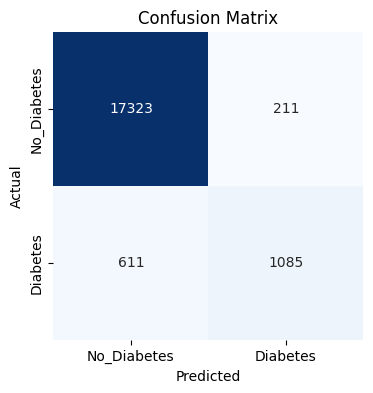

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(SGD_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Estimación de los estadísticos de desempeño del modelo.
print(f'Orden de las etiquetas: {names}')
print(f'Precisión por clase: \t{precision_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{f1_score(y_test, y_pred, average=None)}')

Orden de las etiquetas: ['No_Diabetes', 'Diabetes']
Precisión por clase: 	[0.96593063 0.83719136]
Recall por clase: 	[0.98796624 0.63974057]
Recall por clase: 	[0.97682418 0.72526738]


## **Arbol de Decisión**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
Tree_classifier= DecisionTreeClassifier()
Tree_classifier=Tree_classifier.fit(X_train,y_train)

In [ ]:
print(f'Exactitud en entrenamiento: {Tree_classifier.score(X_train, y_train):.4f}')
print(f'Error en entrenamiento: {1 - Tree_classifier.score(X_train, y_train):.4f}')

Exactitud en entrenamiento: 0.9991
Error en entrenamiento: 0.0009


In [ ]:
print(f'Exactitud en prueba: {Tree_classifier.score(X_test, y_test):.4f}')
print(f'Error prueba: {1 - Tree_classifier.score(X_test, y_test):.4f}')

Exactitud en prueba: 0.9485
Error prueba: 0.0515


In [ ]:
param_grid= {"max_depth": range(1,5,1),
             "criterion": ["gini","entropy"],
             "min_samples_split": range(1,20,1),
             "min_samples_leaf": range(1,20,1)
             }

In [ ]:
grid_clf = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=param_grid,
                        return_train_score=True
)

In [ ]:
grid_clf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
760 fits failed out of a total of 14440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
760 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _va

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 20),
                         'min_samples_split': range(1, 20)},
             return_train_score=True)

In [ ]:
print(grid_clf.best_params_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
print(grid_clf.best_score_)

0.9705522738883943


In [ ]:
grid_clf.score(X_test,y_test)

0.971606864274571

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
lg_DTC= grid_clf.best_estimator_

In [ ]:
y_pred_DTC = lg_DTC.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred_DTC, target_names=['No_Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No_Diabetes       0.97      1.00      0.98     17534
    Diabetes       1.00      0.68      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



In [ ]:
lg_DTC = confusion_matrix(y_test, y_pred_DTC)
list_confusion_matrix(lg_DTC, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17534        0
           Diabetes               546     1150